In [1]:
%matplotlib inline

In [2]:
import signal_to_noise as snr

import numpy as np

import astropy.units as u
from astropy.convolution import discretize_model
from astropy.modeling.functional_models import Moffat2D

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

In [3]:
rcParams['text.usetex'] = True

# Moffat function PSF

## Conversion between FWHM and Moffat function width parameter

In [4]:
def gamma_to_FWHM(gamma, alpha):
    return 2 * gamma * np.sqrt(2**(1 / alpha) - 1)

In [5]:
def FWHM_to_gamma(FWHM, alpha):
    return FWHM / (2 * np.sqrt(2**(1 / alpha) - 1))

## Amplitude required for a normalised Moffat PSF

In [6]:
def amplitude(gamma, alpha, normalisation=1.0):
    return (alpha - 1) / (np.pi * gamma**2)

## Representative examples

Create Moffat functions with three values of the shape parameter:

* 4.765 - best fit for pure Kolmogorov atmospheric turbulence
* 2.5 - default in IRAF, considered typical for astronomical instruments
* 1.5 - extra scattering

In [7]:
g_15 = FWHM_to_gamma(1, 1.5)
m_15 = Moffat2D(amplitude=amplitude(g_15, 1.5), gamma=g_15, alpha=1.5)

g_25 = FWHM_to_gamma(1, 2.5)
m_25 = Moffat2D(amplitude=amplitude(g_25, 2.5), gamma=g_25, alpha=2.5)

g_48 = FWHM_to_gamma(1, 4.765)
m_48 = Moffat2D(amplitude=amplitude(g_48, 4.765), gamma=g_48, alpha=4.765)

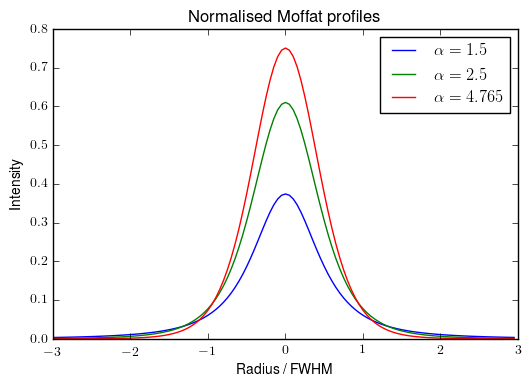

In [8]:
xs = np.arange(-3, 3, 0.05)

plt.plot(xs, m_15(xs, 0), label=r'$\alpha = 1.5$')
plt.plot(xs, m_25(xs, 0), label=r'$\alpha = 2.5$')
plt.plot(xs, m_48(xs, 0), label=r'$\alpha = 4.765$')

plt.title('Normalised Moffat profiles')
plt.xlabel('Radius / FWHM')
plt.ylabel('Intensity')
plt.legend(loc='best')

## Compare discretisation methods

The `astropy.convolution.discretize_model()` function provides four 'modes' for calculating pixellated versions of an `astropy.modelling.FittableModel`:

* center: evaluate the model at the center of each pixel
* linear_interp: evaluate the model at the four corners of each pixel and perform linear interpolation
* oversample: evaluate the model on a sub-pixel grid and sum the results
* integrate: numerically intergrate the model within each pixel

When the core of the PSF spans no more than a few pixels only the latter two are likely to give reasonable results.

### Moffat PSFs with 1 pixel FWHM and shape parameter 2.5

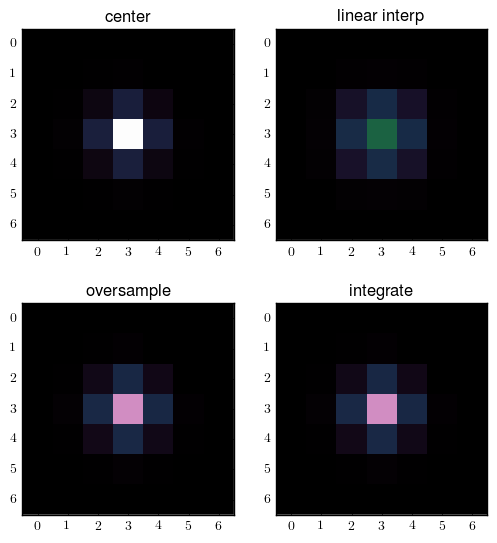

In [9]:
xrange = (-3, 4)
yrange = (-3, 4)

plt.subplot(2,2,1)
plt.imshow(discretize_model(m_25, xrange, yrange, mode='center'), 
           interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('center')

plt.subplot(2,2,2)
plt.imshow(discretize_model(m_25, xrange, yrange, mode='linear_interp'), 
           interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('linear interp')

plt.subplot(2,2,3)
plt.imshow(discretize_model(m_25, xrange, yrange, mode='oversample', factor=10), 
           interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('oversample')

plt.subplot(2,2,4)
plt.imshow(discretize_model(m_25, xrange, yrange, mode='integrate'), 
           interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('integrate')

plt.gcf().set_size_inches(6,6.5)

### Cross sections through Moffat PSFs

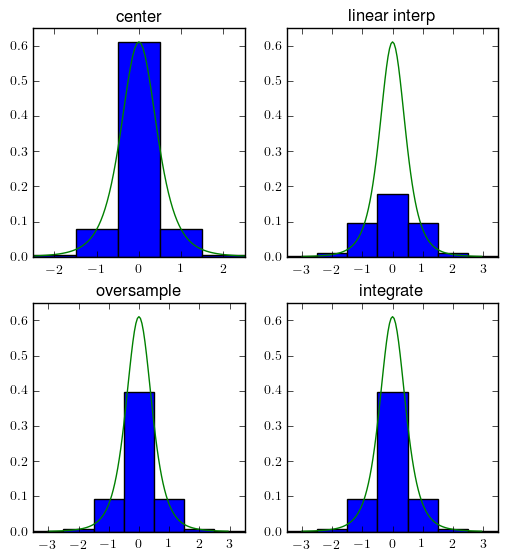

In [10]:
lefts = np.arange(-3.5, 2.51)

plt.subplot(2,2,1)
plt.bar(lefts, discretize_model(m_25, xrange, yrange, mode='center')[3], width=1.0)
plt.plot(xs, m_25(xs, 0), 'g-')
plt.xlim(-2.5, 2.5)
plt.ylim(0, 0.65)
plt.title('center')

plt.subplot(2,2,2)
plt.bar(lefts, discretize_model(m_25, xrange, yrange, mode='linear_interp')[3], width=1.0)
plt.plot(xs, m_25(xs, 0), 'g-')
plt.xlim(-3.5, 3.5)
plt.ylim(0, 0.65)
plt.title('linear interp')

plt.subplot(2,2,3)
plt.bar(lefts, discretize_model(m_25, xrange, yrange, mode='oversample', factor=10)[3], width=1.0)
plt.plot(xs, m_25(xs, 0), 'g-')
plt.xlim(-3.5, 3.5)
plt.ylim(0, 0.65)
plt.title('oversample')

plt.subplot(2,2,4)
plt.bar(lefts, discretize_model(m_25, xrange, yrange, mode='integrate')[3], width=1.0)
plt.plot(xs, m_25(xs, 0), 'g-')
plt.xlim(-3.5, 3.5)
plt.ylim(0, 0.65)
plt.title('integrate')

plt.gcf().set_size_inches(6,6.5)

### Check normalisation

Sum of pixel values should be just less than 1 (due to truncation by 7 x 7 pixel box).

In [11]:
discretize_model(m_25, xrange, yrange, mode='center').sum()

1.1052519901773865

In [12]:
discretize_model(m_25, xrange, yrange, mode='linear_interp').sum()

0.90077546473985126

In [13]:
discretize_model(m_25, xrange, yrange, mode='oversample', factor=10).sum()

0.98882499490218012

In [14]:
discretize_model(m_25, xrange, yrange, mode='integrate').sum()

0.98882060906430647

### Compare evaluation time

`center` and `linear_interp` fast, `integrate` horribly slow. `oversample` results close to `integrate` but only a factor of a few slower than `center`.

In [15]:
%timeit discretize_model(m_25, xrange, yrange, mode='center')

1000 loops, best of 3: 215 µs per loop


In [16]:
%timeit discretize_model(m_25, xrange, yrange, mode='linear_interp')

1000 loops, best of 3: 229 µs per loop


In [17]:
%timeit discretize_model(m_25, xrange, yrange, mode='oversample', factor=10)

1000 loops, best of 3: 711 µs per loop


In [18]:
%timeit discretize_model(m_25, xrange, yrange, mode='integrate')

1 loop, best of 3: 3.09 s per loop


# Signal to noise ratio for PSF fitting photometry

For PSF fitting photometry the measured quantity is the weighted mean of the signals in each pixel ($s_{ij} = S.t_\textrm{exp}.{PSF}_{ij}$), where the optimal weights for each pixel are simply the PSF values for that pixel, ${PSF}_{ij}$, i.e.

$M = \frac{S.t_\textrm{exp}\sum{{PSF}_{ij}^2}}{\sum{{PSF}_{ij}}} = S.t_\textrm{exp}\sum{{PSF}_{ij}^2}$.

The noise in each pixel is given by

$n_{ij} = \sqrt{S.t_\textrm{exp}.{PSF}_{ij} + B.t_\textrm{exp} + D.t_\textrm{exp} + R^2.N_\textrm{sub}} = \sqrt{t_\textrm{exp}}.\sqrt{S.{PSF}_{ij} + B + D + R^2/t_\textrm{sub}} = \sqrt{t_\textrm{exp}}.N_{ij}$,

so the total noise is the weighted mean is given by

$n_\textrm{M} = \sqrt{\sum{{PSF}_{ij}^2.n_{ij}^2}} = \sqrt{t_\textrm{exp}}.\sqrt{\sum{{PSF}_{ij}^2.N_{ij}^2}}$,

so that the effective signal to noise ratio is 

$\frac{M}{n_\textrm{M}} = \frac{S.\sqrt{t_\textrm{exp}}\sum{{PSF}_{ij}^2}}{\sqrt{\sum{{PSF}_{ij}^2.N_{ij}^2}}}$.

In the case where the noise is dominated by sky background and/or instrumental noise (almost always the case when considering the low signal to noise sensitivity limits of astronomical instruments) we can simplify this further. If the $S.{PSF}_{ij}$ term of $N_{ij}$ can be neglected $N_{ij}$ becomes the constant $N = \sqrt{B + D + R^2/t_\textrm{sub}}$, and the effective signal to noise ratio becomes

$\frac{M}{n_\textrm{M}} = \frac{S.\sqrt{t_\textrm{exp}}\sum{{PSF}_{ij}^2}}{N.\sqrt{\sum{{PSF}_{ij}^2.}}} = \frac{S}{N}.\sqrt{t_\textrm{exp}.\sum{{PSF}_{ij}^2}}$.

This is the same signal to noise as would be obtained with a signal evenly spread over $n_\textrm{pix}$ pixels where $n_\textrm{pix} = 1 / \sum{{PSF}_{ij}^2}$.

## Example calculation

In [19]:
# Pixel scale from Canon 2.8/400 + STF-8300M
pix_scale = 2.85 * u.arcsecond / u.pixel

In [20]:
# 1 pixel FWHM, IRAF default 'winginess'
psf = snr.Moffat_PSF(FWHM=pix_scale * u.pixel, alpha=2.5)

In [21]:
# 4 pixellated versions, centred on centre, side, top and corner of pixel
n_pix = 21
psf_pix_centre = psf.pixellated(pix_scale, n_pix, offsets=(0, 0))
psf_pix_side = psf.pixellated(pix_scale, n_pix, offsets=(0.5, 0))
psf_pix_top = psf.pixellated(pix_scale, n_pix, offsets=(0, 0.5))
psf_pix_corner = psf.pixellated(pix_scale, n_pix, offsets=(0.5, 0.5))

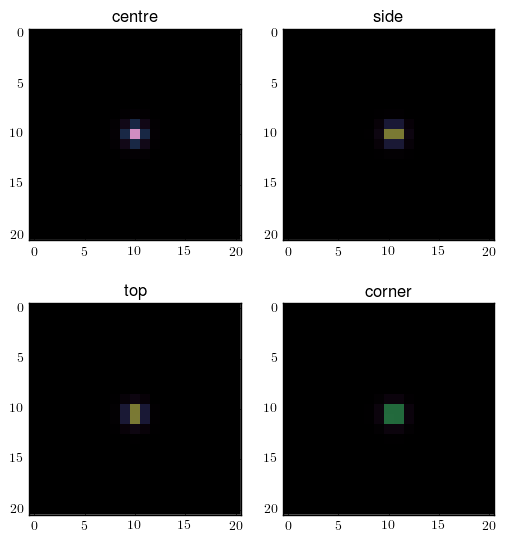

In [22]:
plt.subplot(2,2,1)
plt.imshow(psf_pix_centre, interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('centre')

plt.subplot(2,2,2)
plt.imshow(psf_pix_side, interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('side')

plt.subplot(2,2,3)
plt.imshow(psf_pix_top, interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('top')

plt.subplot(2,2,4)
plt.imshow(psf_pix_corner, interpolation='none', cmap='cubehelix', vmax=0.6)
plt.title('corner')

plt.gcf().set_size_inches(6, 6.5)

In [23]:
# Peak pixel value for a pixel centred PSF, useful for saturation limit calculations
psf.peak(2.85 * u.arcsecond / u.pixel)

0.39748931950876376

In [24]:
# n_pix value as defined above, useful for point source sensitivity limit calculations
psf.n_pix(pix_scale)

6.7810449442290848